# GR Comparison


In [51]:
import rebound
import reboundx
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [38]:
def run(gr=None, swapMasses=False):  
    sim = rebound.Simulation()
    sim.integrator = "ias15"

    if swapMasses:
        sim.add(m=1.66013e-07,x=0.30749903826,vy=1.98009112946) # Mercury-like
        sim.add(m=1.) # Sun
    else:
        sim.add(m=1.) # Sun
        sim.add(m=1.66013e-07,x=0.30749903826,vy=1.98009112946) # Mercury-like
    sim.move_to_com() # Moves to the center of momentum frame

    if gr is not None:
        xs = reboundx.Extras(sim)
        methodToCall = getattr(xs, gr)
        methodToCall()

    sim.integrate(1000.)
    
    juliancentury = 628.33195 # in yr/2pi
    arcsec = 4.8481368e-06 # in rad
    if swapMasses:
        pomega = sim.particles[0].calculate_orbit(sim, primary=sim.particles[1]).pomega
    else:
        pomega = sim.particles[1].calculate_orbit(sim, primary=sim.particles[0]).pomega
    

    return pomega/sim.t*juliancentury/arcsec

In [40]:
modules = ["add_gr", "add_gr_potential", "add_gr_implicit"]

print("Ordered masses...")
for m in modules:
    start = time.time()
    res = run(m)
    end = time.time()
    print("%s:  \t%.10f   %.5fs"%(m,res,end-start))

print("\n\nSwapping masses...")
for m in modules:
    start = time.time()
    res = run(m,swapMasses=True)
    end = time.time()
    print("%s:  \t%.10f   %.5fs"%(m,res,end-start))

Ordered masses...
add_gr:  	43.0327387862   0.46940s
add_gr_potential:  	42.8805602912   0.36737s
add_gr_implicit:  	43.0327339760   1.74182s


Swapping masses...
add_gr:  	71.6198015059   0.45564s
add_gr_potential:  	0.0000000000   0.35604s
add_gr_implicit:  	43.0327339760   1.82993s


In [66]:
def runSS(gr=None):  
    sim = rebound.Simulation.from_file("initial-gr-ss.bin")
    sim.integrator = "ias15"
    sim.move_to_com()

    if gr is not None:
        xs = reboundx.Extras(sim)
        methodToCall = getattr(xs, gr)
        methodToCall()

    N = 1000
    times = np.linspace(1,2.*np.pi*1e4,N)
    es = np.zeros(N)
    for i, t in enumerate(times):
        
        sim.integrate(t,exact_finish_time=1)
        os = sim.calculate_orbits()
        es[i] = os[0].e
    
    return times, es

In [67]:
modules = ["add_gr", "add_gr_potential", "add_gr_implicit"]

results = []
for m in modules:
    start = time.time()
    res = runSS(m)
    end = time.time()
    results.append(res)
    

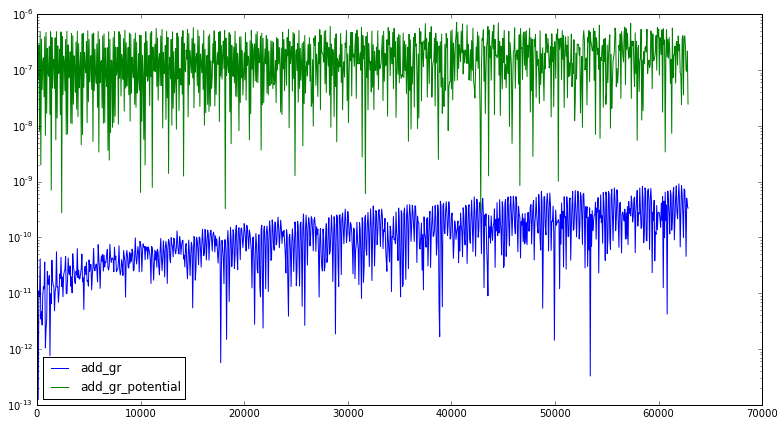

In [68]:
fig = plt.figure(figsize=(13,7))
ax = plt.subplot(111)
ax.set_yscale("log")

for i, m in enumerate(modules):
    if i!=2:
        plt.plot(results[i][0],np.fabs(results[i][1]-results[2][1]), label=m)
plt.legend(loc='lower left')